# Approche descendente (top-down) sur l'apprentissage de QAOA dans un contexte de génie logiciel avec PennyLane

## 1. Introduction à QAOA  
Quantum Approximate Optimization Algorithm (QAOA) est un algorithm hybrid (utilise une partie quantique et classique) pour trouver des solutions à des problèmes d'optimisation. Ultimement, l'algorithme permet d'optimiser une fonction de coût (cost function). Cette fonction de coût encode le problème qu'on veux résoudre. l'intérêt principale de QAOA est pour étudier les problème d'opimization combinatoire pendant l'ère NISQ.

In [ ]:
import pennylane as qml

# Define the graph edges for MaxCut (4-node cycle)
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

coeffs = []
ops = []
for (i, j) in edges:
    coeffs.append(-0.5)                      # coefficient for -0.5 * Z_i Z_j
    ops.append(qml.PauliZ(i) @ qml.PauliZ(j)) # the Pauli Z tensor product on qubits i and j


cost_h = qml.Hamiltonian(coeffs, ops)
print(cost_h)


-0.5 * (Z(0) @ Z(1)) + -0.5 * (Z(1) @ Z(2)) + -0.5 * (Z(2) @ Z(3)) + -0.5 * (Z(3) @ Z(0))


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx


graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from(edges) 

cost_h, mixer_h = qml.qaoa.maxcut(graph)
print("Cost Hamiltonian:", cost_h)
print("Mixer Hamiltonian:", mixer_h)


Cost Hamiltonian: 0.5 * (Z(0) @ Z(1)) + 0.5 * (Z(0) @ Z(3)) + 0.5 * (Z(1) @ Z(2)) + 0.5 * (Z(2) @ Z(3)) + -0.5 * (I(0) @ I(1)) + -0.5 * (I(0) @ I(3)) + -0.5 * (I(1) @ I(2)) + -0.5 * (I(2) @ I(3))
Mixer Hamiltonian: 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [3]:

p = 2  

n_qubits = len(graph.nodes)
dev = qml.device("default.qubit", wires=n_qubits)

def qaoa_layer(gamma, beta):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(beta, mixer_h)

@qml.qnode(dev)
def qaoa_circuit(params):

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    qml.layer(qaoa_layer, p, params[0], params[1])
    return qml.expval(cost_h)


In [4]:
# Test circuit QAOA avec plusieurs paramètres aléatoire
np.random.seed(0)
params = np.random.rand(2, p)
print("Initial cost (expectation value):", qaoa_circuit(params))


Initial cost (expectation value): -0.9757841834970927


In [ ]:
def cost_function(param_vector):
    return qaoa_circuit(param_vector)

optimizer = qml.GradientDescentOptimizer(stepsize=0.4)
num_iterations = 20

current_params = np.random.rand(2, p) 
for it in range(num_iterations):
    current_params, prev_cost = optimizer.step_and_cost(cost_function, current_params)
    if it % 5 == 0:
        print(f"Iteration {it}: cost = {prev_cost:.4f}")


[[0.97861834 0.79915856]
 [0.46147936 0.78052918]]
Iteration 0: cost = -0.6411
[[0.97861834 0.79915856]
 [0.46147936 0.78052918]]
Iteration 5: cost = -0.6411
[[0.97861834 0.79915856]
 [0.46147936 0.78052918]]
Iteration 10: cost = -0.6411
[[0.97861834 0.79915856]
 [0.46147936 0.78052918]]
Iteration 15: cost = -0.6411


c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


In [6]:
final_cost = qaoa_circuit(current_params)
print("Final cost after optimization:", final_cost)


Final cost after optimization: -1.46650891181572


In [ ]:
# sample_result = qaoa_circuit.sample(current_params, shots=100)

# bitstrings = ["".join(map(str, sample)) for sample in sample_result]
# from collections import Counter
# counts = Counter(bitstrings)
# most_common_bitstring, freq = counts.most_common(1)[0]
# print("Most common bitstring from sampling:", most_common_bitstring)


In [7]:
@qml.qnode(dev)
def qaoa_circuit_manual(params):

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for layer in range(p):
        gamma = params[0, layer]
        beta = params[1, layer]
        for (i, j) in graph.edges():
            qml.CNOT(wires=[i, j])
            qml.RZ(2 * gamma, wires=j)    
            qml.CNOT(wires=[i, j])
        for k in range(n_qubits):
            qml.RX(2 * beta, wires=k)
    return qml.expval(cost_h)


In [8]:
test_params = np.random.rand(2, p)
val_builtin = qaoa_circuit(test_params)
val_manual  = qaoa_circuit_manual(test_params)
print(val_builtin, val_manual)

-1.994339583702281 -1.1550748732778762


## Visualization

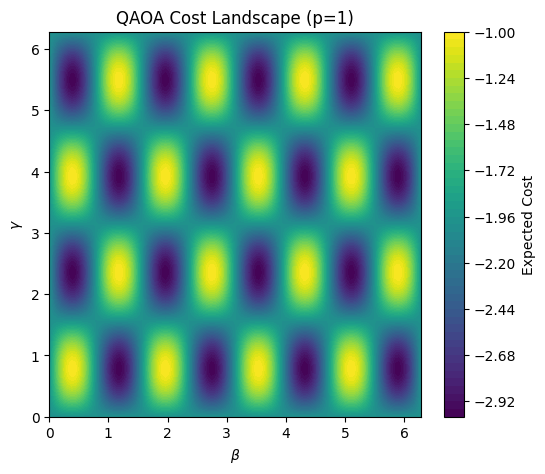

In [24]:
import numpy as np
import matplotlib.pyplot as plt


gamma_vals = np.linspace(0, 2*np.pi, 100)
beta_vals  = np.linspace(0, 2*np.pi, 100)
cost_grid = np.zeros((len(gamma_vals), len(beta_vals)))
current_params = np.random.rand(2, p) 

for i, gamma in enumerate(gamma_vals):
    for j, beta in enumerate(beta_vals):    
        cost_grid[i, j] = qaoa_circuit(np.array([[gamma,0.0],[beta,0.0]])) 

plt.figure(figsize=(6,5))
plt.contourf(beta_vals, gamma_vals, cost_grid, levels=50, cmap='viridis')
plt.colorbar(label="Expected Cost")
plt.xlabel(r"$\beta$"); plt.ylabel(r"$\gamma$")
plt.title("QAOA Cost Landscape (p=1)")
plt.show()
